## Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error # allows us to check RMSE, which is how success is evaluated
# rmse = mean_squared_error({prediction},{target})**0.5

## Examine dataset

In [8]:
raw_data = pd.read_csv('kaggle_data/data.csv', index_col=0)
data = raw_data
data

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
...,...,...,...,...,...,...,...,...,...
31639,Thompson,NaN,NaN,1736.0,0.0886,NaN,7.8,591.0,2.3
31640,NaN,NaN,13.79,NaN,NaN,4.7,4.7,NaN,3.9
31641,Thompson,NaN,18.27,658.0,-0.1224,3.0,3.0,150.0,2.3


## Establish missing rows

In [9]:
missings = data[data['x_e_out [-]'].isna()]
missings

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
7,Peskov,tube,18.00,750.0,NaN,10.0,10.0,1650.0,2.2
10,Thompson,tube,NaN,NaN,NaN,1.9,1.9,152.0,3.2
12,Thompson,NaN,6.89,7500.0,NaN,NaN,12.8,1930.0,4.8
23,Beus,annulus,15.51,1355.0,NaN,5.6,15.2,2134.0,2.1
...,...,...,...,...,...,...,...,...,...
31633,Thompson,tube,11.03,NaN,NaN,11.5,11.5,NaN,2.0
31634,Richenderfer,plate,1.01,2000.0,NaN,15.0,120.0,10.0,6.2
31637,Weatherhead,tube,13.79,688.0,NaN,NaN,11.1,457.0,2.3


## Examine by geometry

In [10]:
geometry = data[['geometry','x_e_out [-]']].groupby('geometry')

In [11]:
geometry.describe()

x_e_out [-]                                                      \
               count      mean       std     min     25%     50%     75%   
geometry                                                                   
annulus       2971.0  0.052503  0.076117 -0.3137  0.0027  0.0409  0.1124   
plate          424.0 -0.033045  0.040430 -0.1491 -0.0434 -0.0218 -0.0103   
tube         14121.0 -0.010808  0.103414 -0.8667 -0.0590 -0.0048  0.0587   

                  
             max  
geometry          
annulus   0.2320  
plate     0.1743  
tube      0.2201

In [12]:
annulus = geometry.describe().loc['annulus'][3:8]
plate = geometry.describe().loc['plate'][3:8]
tube = geometry.describe().loc['tube'][3:8]
geo_dict = {'annulus': annulus, 'plate': plate, 'tube': tube}

<AxesSubplot: >

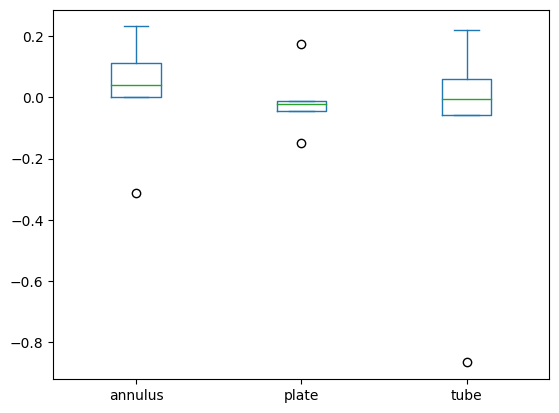

In [13]:
geo_df = pd.DataFrame(geo_dict)
geo_df.plot(kind='box')

## Checking for significance

In [14]:
geom_df = data[['geometry','x_e_out [-]']].dropna()
tube_target = geom_df.loc[geom_df['geometry'] == 'tube']['x_e_out [-]']
annulus_target = geom_df.loc[geom_df['geometry'] == 'annulus']['x_e_out [-]']
plate_target = geom_df.loc[geom_df['geometry'] == 'plate']['x_e_out [-]']

In [15]:
stats.f_oneway(annulus_target, plate_target, tube_target)

F_onewayResult(statistic=533.7585187562129, pvalue=9.595218014078627e-226)

In [16]:
# %conda install statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('data["x_e_out [-]"] ~ geometry', data = data).fit()
geom_anova = sm.stats.anova_lm(model, typ=2)
print(geom_anova)

              sum_sq       df           F         PR(>F)
geometry   10.295740      2.0  533.758519  9.595218e-226
Residual  168.905302  17513.0         NaN            NaN


## Examine by pressure

<AxesSubplot: xlabel='pressure [MPa]', ylabel='x_e_out [-]'>

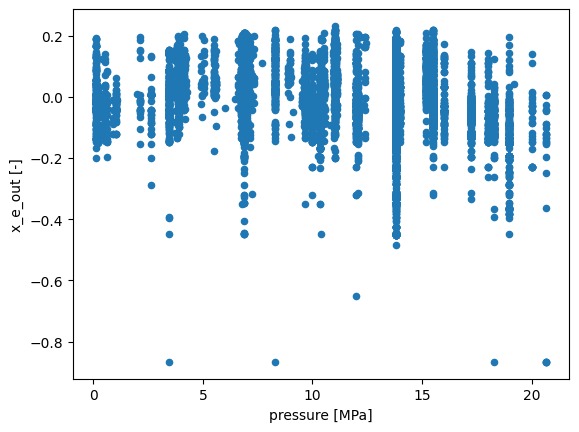

In [17]:
# plot
data.plot(x='pressure [MPa]', y='x_e_out [-]', kind='scatter')

In [18]:
# attempt linear regression

# initialize
mod1 = linear_model.LinearRegression()

# drop nas in data
clean_data = data.dropna()

# train
mod1.fit( X = pd.DataFrame(clean_data['pressure [MPa]']), y = pd.DataFrame(clean_data['x_e_out [-]']) )

# just for testing--examine model
print(mod1.intercept_)
print(mod1.coef_)
mod1.score( X = pd.DataFrame(clean_data['pressure [MPa]']), y = pd.DataFrame(clean_data['x_e_out [-]']) )

[0.04871111]
[[-0.00464584]]


0.03723017362291203

## Examine by mass_flux

<AxesSubplot: xlabel='mass_flux [kg/m2-s]', ylabel='x_e_out [-]'>

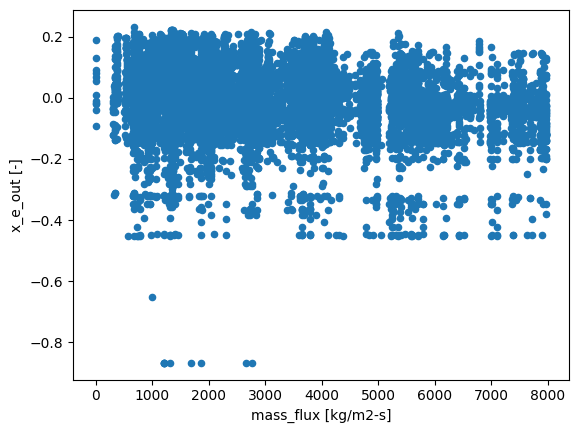

In [19]:
data.plot(kind='scatter', x='mass_flux [kg/m2-s]', y='x_e_out [-]')

In [20]:
# attempt linear regression

# initialize
mod2 = linear_model.LinearRegression()

# drop nas in data
clean_data = data.dropna()

# train
mod2.fit( X = pd.DataFrame(clean_data['mass_flux [kg/m2-s]']), y = pd.DataFrame(clean_data['x_e_out [-]']) )

# just for testing--examine model
print(mod2.intercept_)
print(mod2.coef_)
mod2.score( X = pd.DataFrame(clean_data['mass_flux [kg/m2-s]']), y = pd.DataFrame(clean_data['x_e_out [-]']) )

[0.03047206]
[[-1.02478791e-05]]


0.031306287784076514

## Examine by D_e 

<AxesSubplot: xlabel='D_e [mm]', ylabel='x_e_out [-]'>

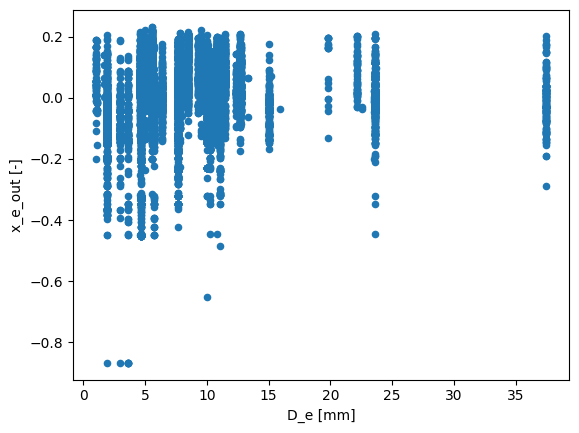

In [21]:
data.plot(kind='scatter', x='D_e [mm]', y='x_e_out [-]')

## Examine by D_h

<AxesSubplot: xlabel='D_h [mm]', ylabel='x_e_out [-]'>

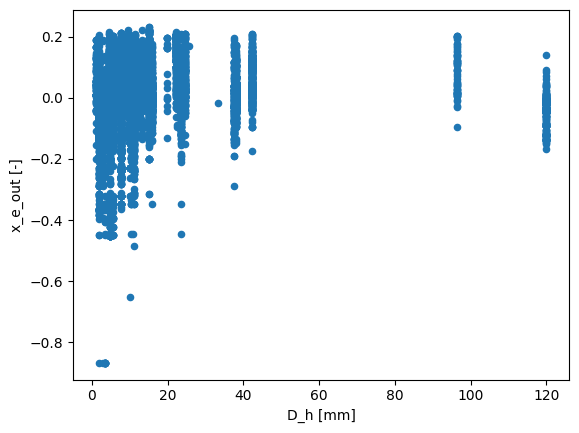

In [22]:
data.plot(kind='scatter', x='D_h [mm]', y='x_e_out [-]')

In [23]:
# attempt linear regression

# initialize
mod3 = linear_model.LinearRegression()

# drop nas in data
clean_data = data.dropna()

# train
mod3.fit( X = pd.DataFrame(clean_data['D_h [mm]']), y = pd.DataFrame(clean_data['x_e_out [-]']) )

# just for testing--examine model
print(mod3.intercept_)
print(mod3.coef_)
mod3.score( X = pd.DataFrame(clean_data['D_h [mm]']), y = pd.DataFrame(clean_data['x_e_out [-]']) )

[-0.0068162]
[[0.00042258]]


0.006353863061439258

[-0.06410928]
[[0.02864938]]


0.058292295738606614

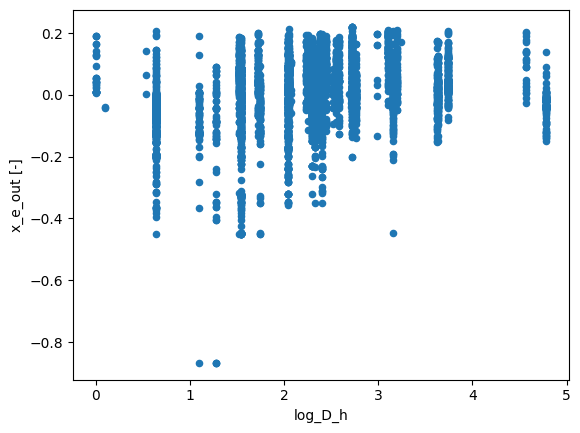

In [24]:
# applying a log transformation
transformed_data = data
transformed_data['log_D_h'] = np.log(clean_data['D_h [mm]'])

transformed_data.plot(kind='scatter', x='log_D_h', y='x_e_out [-]')

# attempt linear regression

# initialize
mod3a = linear_model.LinearRegression()

# drop nas in data
clean_log_data = transformed_data.dropna()

# train
mod3a.fit( X = pd.DataFrame(clean_log_data['log_D_h']), y = pd.DataFrame(clean_log_data['x_e_out [-]']) )

# just for testing--examine model
print(mod3a.intercept_)
print(mod3a.coef_)
mod3a.score( X = pd.DataFrame(clean_log_data['log_D_h']), y = pd.DataFrame(clean_log_data['x_e_out [-]']) )

## Examine by length

<AxesSubplot: xlabel='length [mm]', ylabel='x_e_out [-]'>

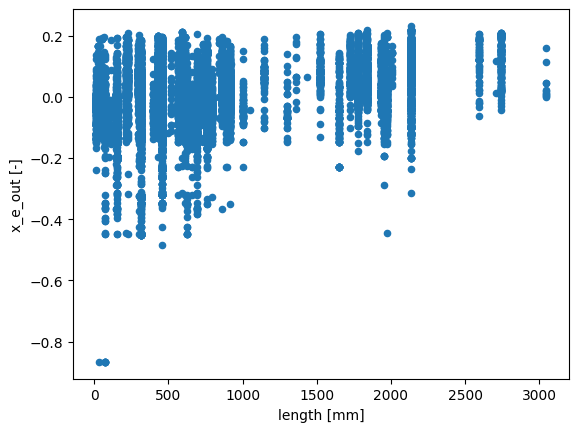

In [25]:
data.plot(kind='scatter', x='length [mm]', y='x_e_out [-]')

In [26]:
# attempt linear regression

# initialize
mod4 = linear_model.LinearRegression()

# drop nas in data
clean_data = data.dropna()

# train
mod4.fit( X = pd.DataFrame(clean_data['length [mm]']), y = pd.DataFrame(clean_data['x_e_out [-]']) )

# just for testing--examine model
print(mod4.intercept_)
print(mod4.coef_)
mod4.score( X = pd.DataFrame(clean_data['length [mm]']), y = pd.DataFrame(clean_data['x_e_out [-]']) )

[-0.04436133]
[[5.18547814e-05]]


0.11536435680399837

## Examine by chf_exp

<AxesSubplot: xlabel='chf_exp [MW/m2]', ylabel='x_e_out [-]'>

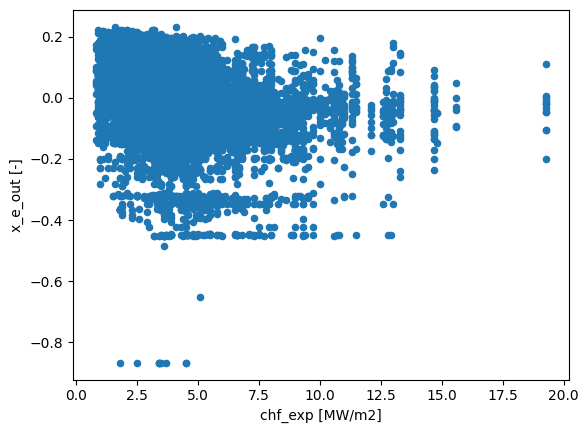

In [27]:
data.plot(kind='scatter', x='chf_exp [MW/m2]', y='x_e_out [-]')

In [70]:
# attempt linear regression

# initialize
mod5 = linear_model.LinearRegression()

# drop nas in data
clean_data = data.dropna()

# train
mod5.fit( X = pd.DataFrame(clean_data['chf_exp [MW/m2]']), y = pd.DataFrame(clean_data['x_e_out [-]']) )

# just for testing--examine model
print(mod5.intercept_)
print(mod5.coef_)
mod5.score( X = pd.DataFrame(clean_data['chf_exp [MW/m2]']), y = pd.DataFrame(clean_data['x_e_out [-]']) )

[0.0774851]
[[-0.02058771]]


0.15090675537717435

[0.11226266]
[[-0.09253105]]


0.1844011470029573

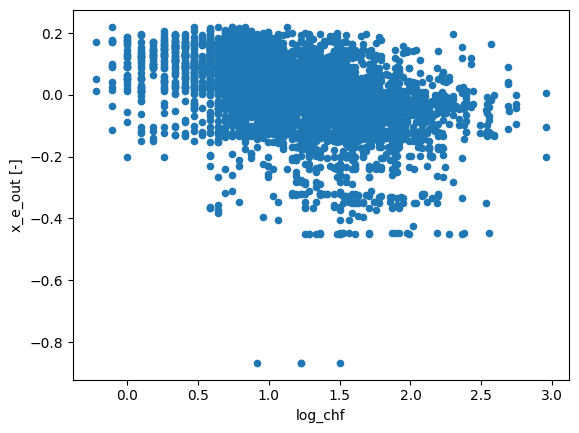

In [71]:
# applying a log transformation
transformed_data = data
transformed_data['log_chf'] = np.log(clean_data['chf_exp [MW/m2]'])

transformed_data.plot(kind='scatter', x='log_chf', y='x_e_out [-]')

# attempt linear regression

# initialize
mod5a = linear_model.LinearRegression()

# drop nas in data
clean_log_data = transformed_data.dropna()

# train
mod5a.fit( X = pd.DataFrame(clean_log_data['log_chf']), y = pd.DataFrame(clean_log_data['x_e_out [-]']) )

# just for testing--examine model
print(mod5a.intercept_)
print(mod5a.coef_)
mod5a.score( X = pd.DataFrame(clean_log_data['log_chf']), y = pd.DataFrame(clean_log_data['x_e_out [-]']) )

## Building multivariable model

In [72]:
# creating dataframe of dummy variables

data_dummies = pd.get_dummies(data=data.geometry) # from all data
clean_dummies = pd.get_dummies(data=clean_data.geometry) # from cleaned data

clean_data['annulus'] = clean_dummies['annulus']



/tmp/ipykernel_344/3775892840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['annulus'] = clean_dummies['annulus']


#### Lee's proposal

- Use OneHotEncoder
- We have two categorical features, geometry and author

In [73]:
from sklearn.preprocessing import OneHotEncoder

author_encoder = OneHotEncoder(drop = 'first'); geometry_encoder = OneHotEncoder(drop = 'first') # Why drop first? 
author_incidence_matrix = author_encoder.fit_transform(clean_data.author.to_numpy().reshape(-1, 1)).toarray()
geometry_incidence_matrix = geometry_encoder.fit_transform(clean_data.geometry.to_numpy().reshape(-1, 1)).toarray()

In [77]:
clean_data_numeric = clean_data.drop(['author','geometry','annulus'], axis = 1)
clean_data_numeric = clean_data_numeric.reset_index(drop = True)
output = clean_data_numeric['x_e_out [-]'].to_numpy().reshape(-1,1)
numeric_inputs = clean_data_numeric.loc[:, ~clean_data_numeric.columns.str.contains('x_e_out [-]')].to_numpy()

In [84]:
raw_inputs = np.concatenate([numeric_inputs, author_incidence_matrix, geometry_incidence_matrix], axis = 1)

In [87]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias = False) # Why include_bias is False? -> model will create the bias column for you
poly_inputs = poly.fit_transform(raw_inputs)

In [99]:
from sklearn.linear_model import Lasso, Ridge

ridge_test = Ridge()
lasso_test = Lasso()

In [100]:
ridge_test.fit(poly_inputs, output)
lasso_test.fit(poly_inputs, output)

/root/Kaggle_1/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.60111e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Lasso()

In [101]:
ridge_test.score(poly_inputs, output), lasso_test.score(poly_inputs, output)

(0.9980283239535434, 0.8083617808821052)

#### It seems like the $X^tX + \lambda I$ is not invertible in Ridge regression

#### End of Lee's suggestion on creating and using quadratic and interaction terms

In [62]:
# initialize
multi_mod = linear_model.LinearRegression()

# this is the structure we need to use to set up multiple predictors
# (I am following this tutorial: https://www.youtube.com/watch?v=O0HQnTJhr70&t=961s)
# just putting everything in here for now
predictors = pd.DataFrame([ clean_log_data['log_chf'], 
                           clean_data['length [mm]'],
                           clean_log_data['log_D_h'], 
                           clean_data['mass_flux [kg/m2-s]'], 
                           clean_data['pressure [MPa]'],
                           clean_dummies.annulus,
                           clean_dummies.plate]).T

### then try lasso, ridge, and elastic net
### refresh on generator objects
### sklearn encoder categorical variables

# fit model to data
multi_mod.fit( X = predictors, y = clean_data['x_e_out [-]'] )

multi_mod.score( X = predictors, y = clean_data['x_e_out [-]'] )

0.3299060228364936

In [ ]:
# look for possible interactions

### research class variables